In [1]:
## load useful libraries
# suppressWarnings(suppressPackageStartupMessages(library(rhdf5)))
# suppressWarnings(suppressPackageStartupMessages(library(qvalue)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))
# suppressWarnings(suppressPackageStartupMessages(library(cowplot)))
# suppressWarnings(suppressPackageStartupMessages(library(tidyverse)))
# suppressWarnings(suppressPackageStartupMessages(library(ggbeeswarm)))
# suppressWarnings(suppressPackageStartupMessages(library(ggthemes)))
# suppressWarnings(suppressPackageStartupMessages(library(scater)))
suppressWarnings(suppressPackageStartupMessages(library(SingleCellExperiment)))
# suppressWarnings(suppressPackageStartupMessages(library(edgeR)))
# suppressWarnings(suppressPackageStartupMessages(library(limma)))
# suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
# suppressWarnings(suppressPackageStartupMessages(library(ISLR)))
# suppressWarnings(suppressPackageStartupMessages(library(GGally)))
suppressWarnings(suppressPackageStartupMessages(library(scran)))
# suppressWarnings(suppressPackageStartupMessages(library(ComplexHeatmap)))
# suppressWarnings(suppressPackageStartupMessages(library(circlize)))

In [2]:
# load sceset
sce = readRDS("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/merged/20180618/sce_merged_afterqc_filt_allexpts.rds")

In [3]:
sce

class: SingleCellExperiment 
dim: 11231 36044 
metadata(4): log.exprs.offset log.exprs.offset log.exprs.offset
  log.exprs.offset
assays(3): tpm counts logcounts
rownames(11231): ENSG00000000003_TSPAN6 ENSG00000000419_DPM1 ...
  ENSG00000272325_NUDT3 ENSG00000272398_CD24
rowData names(17): exprs_collapsed_to ensembl_transcript_id ...
  is_intop2000hvg is_hvg
colnames(36044): 21843_1#10 21843_1#100 ... 24539_8#97 24539_8#98
colData names(123): adj_x adj_y ... princ_curve princ_curve_scaled01
reducedDimNames(1): PCA
spikeNames(1): ERCC

In [4]:
# day0
sce0 = sce[,sce$day == "day0"]

In [5]:
table(sce0$donor,sce0$experiment)

      
       expt_12 expt_18 expt_20 expt_22 expt_23 expt_24 expt_27 expt_28 expt_29
  aowh       0       0       0       0       0       0       0       0      73
  aoxv       0       0       0       0       0       0       0       0       0
  babz       0       0       0       0       0      28       0       0       0
  bezi       0       0       0       0       0       0       0       0       0
  bokz       0       0       0       0       0       0       0       0       0
  cicb       0       0       0       0       0       0       0       0       0
  ciwj       0       0       0       0       0       0       0       0       0
  cuhk       0       0       0       0       0       0       0       0       0
  datg       0       0       0       0       0       0       0       0       0
  eesb       0       0       0       0       0       0       0       0       0
  eipl       0       0       0       0       0       0       0       0       0
  eiwy       0       0       0       0       

In [6]:
get_combinations <- function(sceset, day){
    l = c()
    mysce = sceset[,sceset$day == day]
    mat = table(mysce$donor_short_id, mysce$experiment) 
    ord = which(table(mysce$donor_short_id, mysce$experiment) > 1, arr.ind = T)
    for (i in 1:dim(ord)[1]){
        l[i] = paste0(rownames(mat)[ord[i,1]],"-",colnames(mat)[ord[i,2]])
    }
    l
}

In [7]:
l_day0 <- get_combinations(sce, "day0")

In [50]:
get_means_byexpt <- function(sceset, ngenes, l){
    n = length(l)
    means <- matrix(0,nrow = ngenes, ncol = n)
    for (i in 1:n){
        don = gsub("*-.*","",l[i])
        expt = gsub(".*-","",l[i])
        sc <- sceset[,sceset$donor_short_id == don & sceset$experiment == expt]
        if (ncol(sc) > 1){
            sc1 = logcounts(sc)
            m <- rowMeans(sc1)
            means[,i] = m 
            
        }
        else if (ncol(sc) == 1){
            means[,i] = sc1
        }
    }
    rownames(means) = rownames(sceset)
    colnames(means) = l
    means
}

In [56]:
get_vars_byexpt <- function(sceset, ngenes, l){
    n = length(l)
    vars <- matrix(0,nrow = ngenes, ncol = n)
    cv_means <- matrix(0,nrow = ngenes, ncol = n)
    alphas <- matrix(0,nrow = ngenes, ncol = n)
    for (i in 1:n){
        don = gsub("*-.*","",l[i])
        expt = gsub(".*-","",l[i])
        sc <- sceset[,sceset$donor_short_id == don & sceset$experiment == expt]
        if (ncol(sc) > 1){
            sc1 = logcounts(sc)
            m <- rowMeans(sc1)
            v <- rowVars(sc1)
            vars[,i] = v 
            cv2 <- v/(m**2+1e-15)
            y.loess <- loess(cv2 ~ m, span = 1, data.frame(x = m, y = cv2))
            y.predict <- predict(y.loess, data.frame(x = m))
            cv_means[,i] = cv2 - y.predict 
            y.loess <- loess(v ~ m, span = 1, data.frame(x = m, y = v))
            y.predict <- predict(y.loess, data.frame(x = m))
            alphas[,i] = v - y.predict 
            
        }
        else if (ncol(sc) == 1){
            vars[,i] = sc1
            cv_means[,i] = sc1
            alphas[,i] = sc1
        }
    }
    rownames(vars) = rownames(sceset)
    colnames(vars) = l
    rownames(cv_means) = rownames(sceset)
    colnames(cv_means) = l
    rownames(alphas) = rownames(sceset)
    colnames(alphas) = l
    list(vars,cv_means,alphas)
}

In [51]:
ngenes = nrow(sce0)
means_day0 = get_means_byexpt(sce0, ngenes, l_day0)

In [57]:
ngenes = nrow(sce0)
variances = get_vars_byexpt(sce0, ngenes, l_day0)

In [58]:
var_day0 = variances[[1]]
corr_cv2_day0 = variances[[2]]
alphas_day0 = variances[[3]]

In [59]:
var_day0[1:5,1:5]

,heth_1-expt_12,jogf_2-expt_12,pelm_3-expt_12,vass_1-expt_12,wibj_2-expt_12
ENSG00000000003_TSPAN6,0.6671107,0.6378114,1.3923671,0.8525108,0.5565701
ENSG00000000419_DPM1,1.9293960,2.8505753,2.7046106,2.4064404,1.0991585
ENSG00000000457_SCYL3,1.0081050,0.7236877,0.7989751,0.7537102,0.5754455
ENSG00000000460_C1orf112,2.4642138,1.9138507,1.7362469,2.6354355,1.5498785
ENSG00000001036_FUCA2,2.3829311,1.2573425,1.1246127,1.6317435,0.4971428


In [60]:
corr_cv2_day0[1:5,1:5]

,heth_1-expt_12,jogf_2-expt_12,pelm_3-expt_12,vass_1-expt_12,wibj_2-expt_12
ENSG00000000003_TSPAN6,0.5147516,0.4233494,0.5096991,0.28137091,0.2932841
ENSG00000000419_DPM1,0.5528837,0.4882425,0.5048372,0.32294095,0.3223303
ENSG00000000457_SCYL3,-1.7962080,-3.1045919,-2.0098541,-1.55061822,-0.2077852
ENSG00000000460_C1orf112,-0.2095168,0.3339442,0.3991715,-0.03742694,0.1461086
ENSG00000001036_FUCA2,0.4994222,0.9090418,0.6956566,0.57169311,0.4736345


In [61]:
alphas_day0[1:5,1:5]

,heth_1-expt_12,jogf_2-expt_12,pelm_3-expt_12,vass_1-expt_12,wibj_2-expt_12
ENSG00000000003_TSPAN6,-1.8420438,-1.1449858,-0.5148071,-0.7992867,-0.15910594
ENSG00000000419_DPM1,-0.5165394,1.0844936,0.9429040,0.8118988,0.29302038
ENSG00000000457_SCYL3,-0.5458417,-0.5263343,-0.4592969,-0.4930125,-0.56079124
ENSG00000000460_C1orf112,-0.1587762,-0.3514319,-0.4041180,0.5974203,-0.09217997
ENSG00000001036_FUCA2,-0.4594156,-0.9689593,-0.9727668,-0.3603252,-0.82335461


In [62]:
write.csv(var_day0, file = "/hps/nobackup/stegle/users/acuomo/singlecell_endodiff/variances/day0/var_logcounts.csv")

In [63]:
write.csv(corr_cv2_day0, "/hps/nobackup/stegle/users/acuomo/singlecell_endodiff/variances/day0/cv2_meancorrected_logcounts.csv")

In [64]:
write.csv(alphas_day0, "/hps/nobackup/stegle/users/acuomo/singlecell_endodiff/variances/day0/var_meancorrected_logcounts.csv")

In [52]:
means_day0[1:5,1:5]

,heth_1-expt_12,jogf_2-expt_12,pelm_3-expt_12,vass_1-expt_12,wibj_2-expt_12
ENSG00000000003_TSPAN6,5.4632047,5.6820488,5.3074002,5.506002,6.3659630
ENSG00000000419_DPM1,5.6715785,5.7310043,5.9843245,5.725868,6.0598796
ENSG00000000457_SCYL3,0.8182803,0.6414515,0.6353295,0.581360,0.4119406
ENSG00000000460_C1orf112,2.5504603,2.8950541,3.2537240,2.519451,3.0985460
ENSG00000001036_FUCA2,3.7506864,4.3117687,4.4125005,4.371433,4.6400641


In [53]:
write.csv(means_day0, "/hps/nobackup/stegle/users/acuomo/singlecell_endodiff/variances/day0/mean_logcounts.csv")

[1] "heth_1-expt_12"

[1] 26

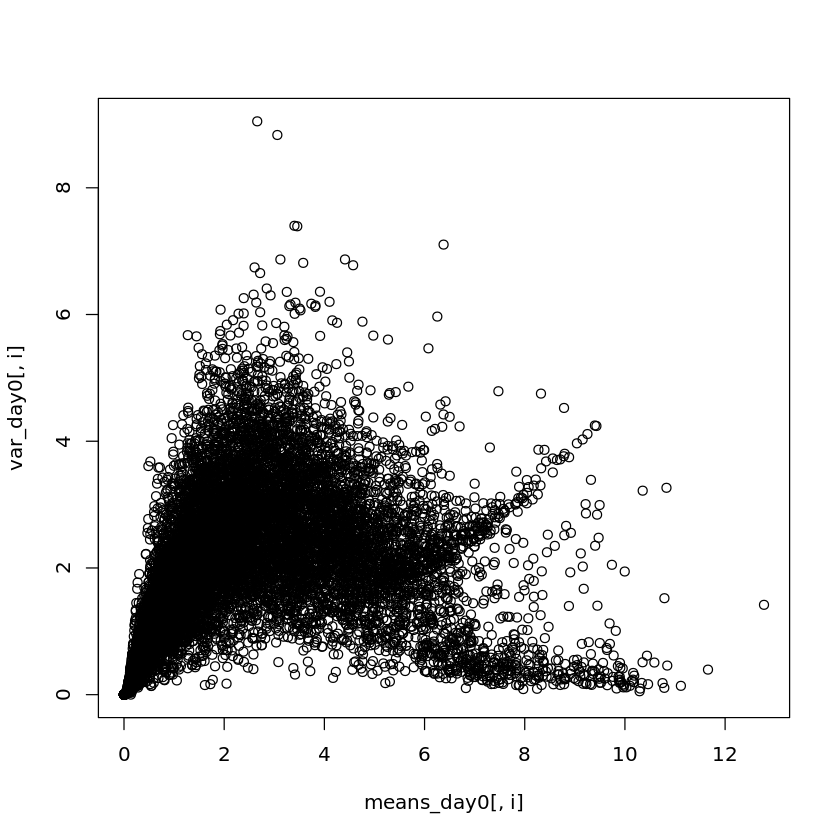

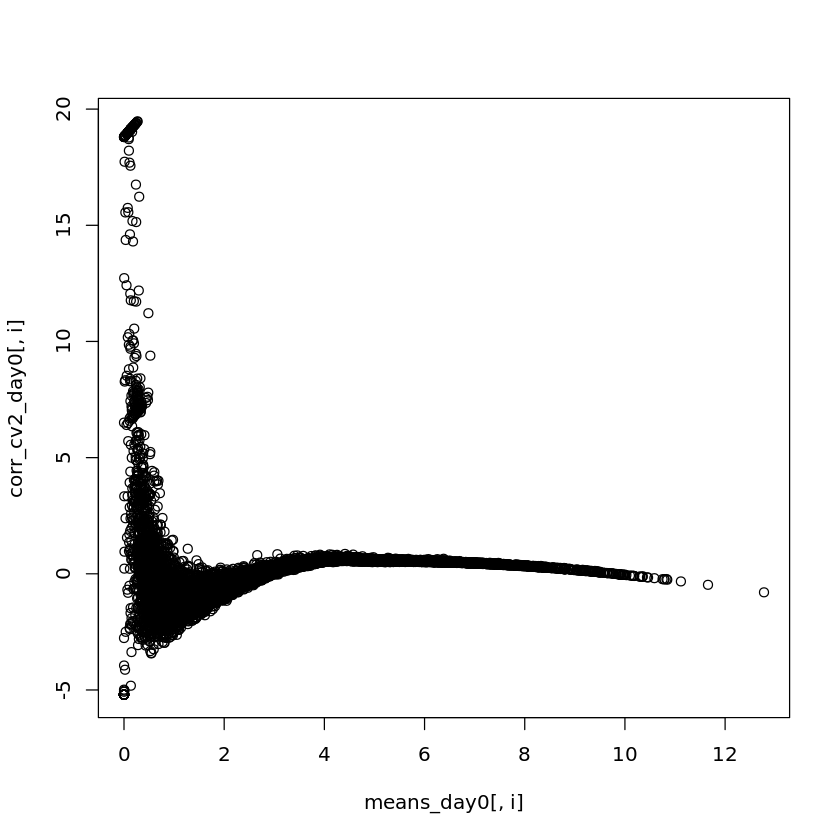

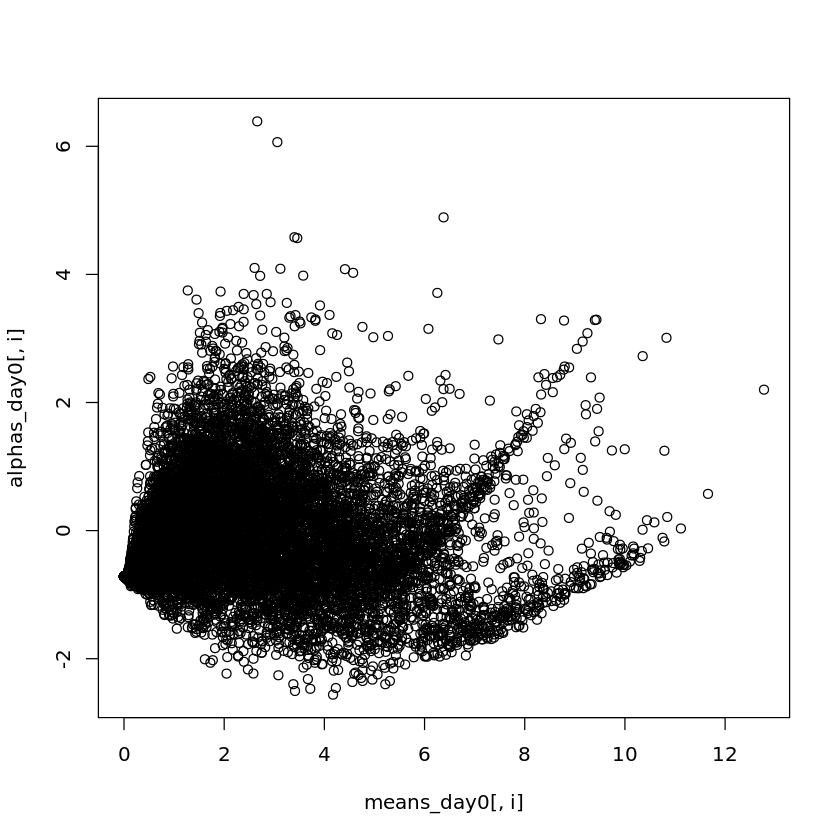

In [55]:
i = 1
l_day0[i]
sum(table(sce0$donor == gsub("_.*","",l_day0[i]),sce0$experiment)>0)
# plot(var_day0[,i],alphas_day0[,i])
# plot(var_day0[,i],corr_cv2_day0[,i])
# plot(alphas_day0[,i],corr_cv2_day0[,i])
plot(means_day0[,i],var_day0[,i])
plot(means_day0[,i],corr_cv2_day0[,i])
plot(means_day0[,i],alphas_day0[,i])

In [47]:
for (i in 1:length(l_day0)){
    print(l_day0[i])
    print(table(sce0$donor == gsub("_.*","",l_day0[i]))[2])
    print(cor(var_day0[,i],alphas_day0[,i]))
    print(cor(var_day0[,i],corr_cv2_day0[,i]))
    print(cor(alphas_day0[,i],corr_cv2_day0[,i]))
}

[1] "heth_1-expt_12"
TRUE 
  54 
[1] 0.8540204
[1] -0.01970125
[1] 0.03319602
[1] "jogf_2-expt_12"
TRUE 
 102 
[1] 0.8542656
[1] -0.08069334
[1] -0.04431474
[1] "pelm_3-expt_12"
TRUE 
 222 
[1] 0.9077718
[1] -0.08007704
[1] -0.04473711
[1] "vass_1-expt_12"
TRUE 
 106 
[1] 0.9191211
[1] -0.05251806
[1] -0.001824296
[1] "wibj_2-expt_12"
TRUE 
  51 
[1] 0.9231525
[1] -0.09249127
[1] -0.03197974
[1] "zapk_3-expt_12"
TRUE 
 214 
[1] 0.9139581
[1] -0.08448932
[1] -0.03657873
[1] "oaqd_3-expt_18"
TRUE 
  80 
[1] 0.9242389
[1] -0.1333287
[1] -0.08835793
[1] "paab_4-expt_18"
TRUE 
 166 
[1] 0.9155418
[1] -0.1375655
[1] -0.08227681
[1] "sita_1-expt_18"
TRUE 
  69 
[1] 0.9100089
[1] -0.1354029
[1] -0.08816241
[1] "toss_3-expt_18"
TRUE 
  42 
[1] 0.9292281
[1] -0.1214128
[1] -0.06349079
[1] "zoio_2-expt_18"
TRUE 
  27 
[1] 0.9282797
[1] -0.1210733
[1] -0.05277697
[1] "fasu_2-expt_20"
TRUE 
  20 
[1] 0.7698143
[1] -0.05678509
[1] -0.01188324
[1] "iudw_4-expt_20"
TRUE 
  44 
[1] 0.8751117
[1] 0.0402

In [46]:
table(sce0$donor == gsub("_.*","",l_day0[i]))[2]

TRUE 
  92